In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling, ERFUpsampling,ERFUpsamplingFast, cut_model_from_layer, cut_model_to_layer
from data import PascalVOC2007, imagenettewoof
from results.results_metrics import ResultMetrics
from models import vgg11_PascalVOC, vgg_preprocess, vgg11_Imagenettewoof

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_Imagenettewoof()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_Imagenettewoof.pth', map_location=device))
model.eval()

preprocess = vgg_preprocess

In [3]:
train_data = imagenettewoof(split="train",size="320px", transform=preprocess)
val_data = imagenettewoof(split="val", size="320px",transform=preprocess)

data\imagewoof2-320
data\imagewoof2-320


In [4]:
import torch.utils
from torch.utils.data import Subset

BATCH_SIZE_TEST = 1
NUM_TEST = 128

NUM_TRAIN = 8
BATCH_SIZE_TRAIN = 1

dl_test = DataLoader(Subset(val_data, torch.randperm(len(val_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=False)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=False)

In [5]:
baseline_dist = torch.stack([train_data[i][0] for i in range(NUM_TRAIN)])
print(baseline_dist.shape)

torch.Size([8, 3, 224, 224])


torch.Size([1, 1, 7, 7])


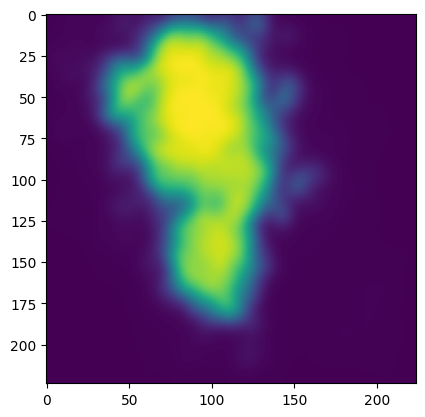

torch.Size([1, 1, 28, 28])


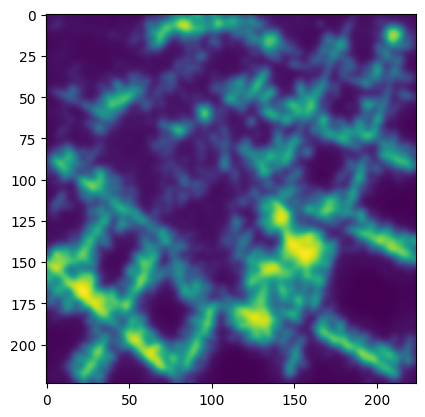

torch.Size([1, 1, 112, 112])


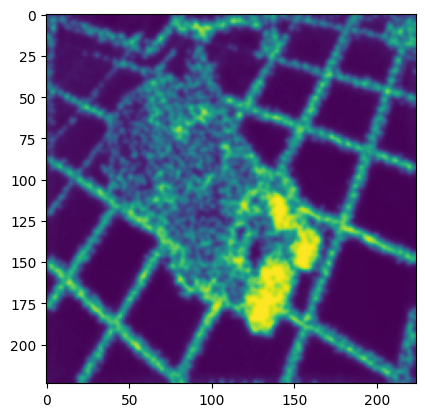

In [19]:
from utils import _GradCAMPlusPlus, ERFUpsamplingFast
import matplotlib.pyplot as plt
LAYERS = [model.features[i] for i in [20, 10, 3]]
# LAYERS = [model.features[i] for i in [2]]

attributions = []
INDEX = 6042
for layer in LAYERS:
    attribution = _GradCAMPlusPlus(model, target_layer=layer)
    # attribution = _DeepLiftShap()
    upscale = ERFUpsamplingFast(model, layer, device)
    # upscale = SimpleUpsampling((224,224))

    for i in [INDEX]:
    # for i, (img, target) in enumerate(dl_test):
        img, target = val_data[i]
        img = img.to(device).unsqueeze(0)
        target = torch.Tensor([target]).type(dtype=torch.int64).to(device).reshape(-1)
        
        # plt.imshow(img[0].detach().cpu().numpy().transpose(1,2,0))
        plt.show()

        attribution_map = attribution.attribute(img, model, layer, target, baseline_dist)
        
        print(attribution_map.shape)
        # plt.imshow(attribution_map[0].detach().cpu().numpy().transpose(1,2,0))
        # plt.show()

        upscaled_attribution = upscale(attribution_map, img)
        attributions.append(upscaled_attribution)
        # print(upscaled_attribution.shape)
        plt.imshow(upscaled_attribution[0].detach().cpu().numpy().transpose(1,2,0))
        plt.show()
        break

In [7]:
((64*112*112)*4) / (1024**2)

3.0625

$$f(x_1, \dots, x_n) = \frac{\ln (n) + 1}{\ln \left( \sum_{i=1}^{n}e^{\frac{1}{x_i}} \right)}$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


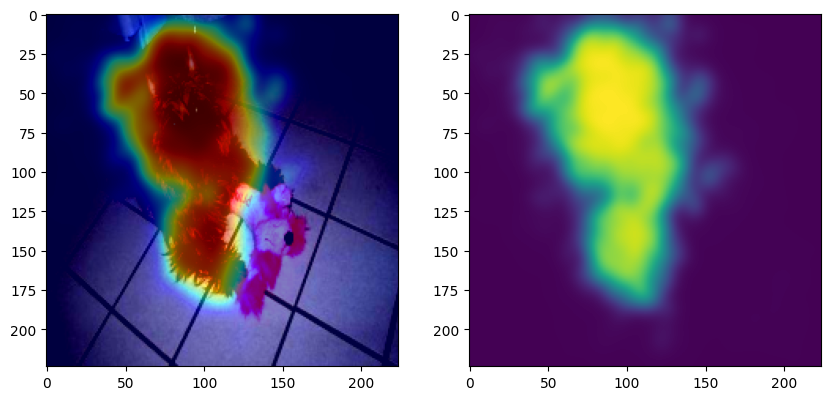

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


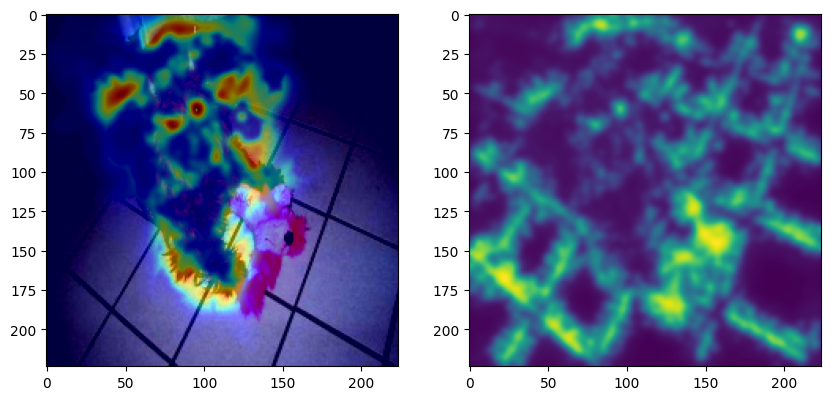

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


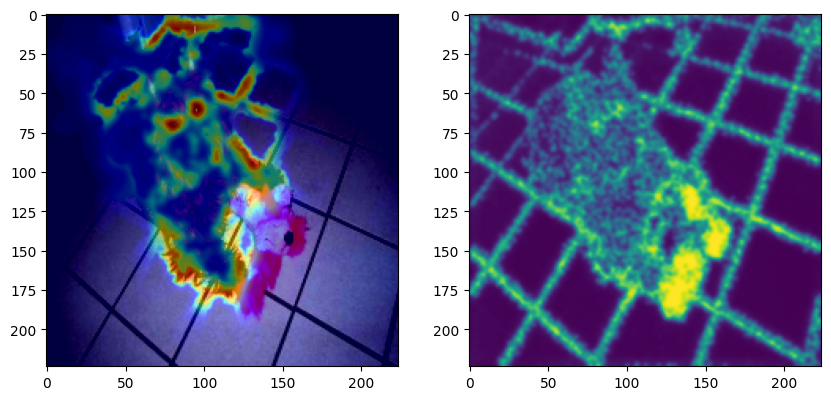

In [29]:
from utils import LogExpMix, MultiplierMix

for i, layer in enumerate(LAYERS):
    attributions_up_to_layer = [attributions[j][0] for j in range(i+1)]
    mixed_attributions = LogExpMix("all")(attributions_up_to_layer)
    # mixed_attributions = LogExpMix("top")(attributions_up_to_layer)
    # mixed_attributions = LogExpMix("above")(attributions_up_to_layer)

    # mixed_attributions = MultiplierMix("all")(attributions_up_to_layer)
    # mixed_attributions = MultiplierMix("top")(attributions_up_to_layer)
    # mixed_attributions = MultiplierMix("above")(attributions_up_to_layer)

    image, label = val_data[INDEX]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image.detach().cpu().numpy().transpose(1,2,0))
    plt.imshow(mixed_attributions.detach().cpu().numpy().transpose(1,2,0), alpha=0.5, cmap='jet')
    
    plt.subplot(1,2,2)
    plt.imshow(attributions[i][0].detach().cpu().numpy().transpose(1,2,0))
    plt.show()

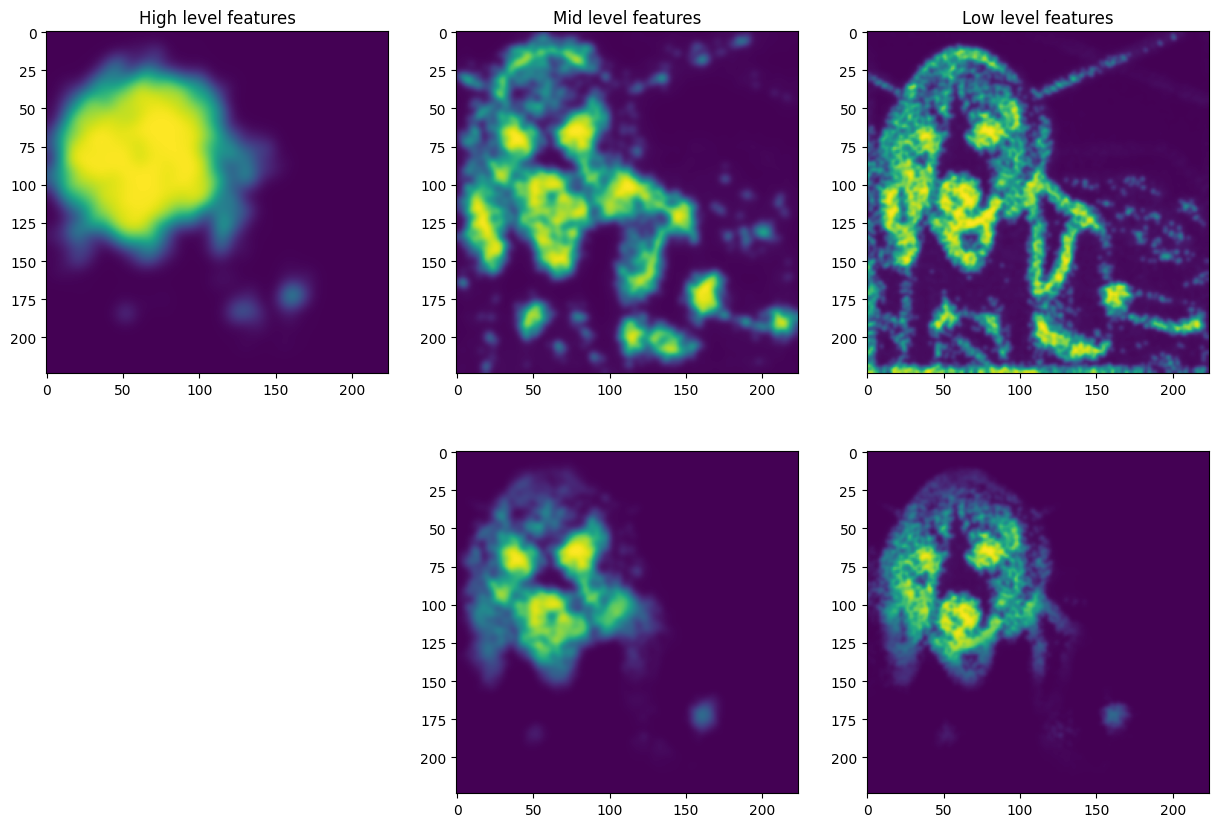

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title("High level features")
plt.imshow(attributions[0][0].detach().cpu().numpy().transpose(1,2,0))
plt.subplot(2,3,2)
plt.title("Mid level features")
plt.imshow(attributions[1][0].detach().cpu().numpy().transpose(1,2,0))
plt.subplot(2,3,3)
plt.title("Low level features")
plt.imshow(attributions[2][0].detach().cpu().numpy().transpose(1,2,0))

plt.subplot(2,3,5)
combined = attributions[0] * attributions[1]
plt.imshow(combined[0].detach().cpu().numpy().transpose(1,2,0))
plt.subplot(2,3,6)
combined = attributions[0] * attributions[2]
plt.imshow(combined[0].detach().cpu().numpy().transpose(1,2,0))

In [3]:
res = {'Class 0': 93.02325581395348,
 'Class 1': 77.46835443037975,
 'Class 2': 92.43697478991596,
 'Class 3': 59.32642487046632,
 'Class 4': 87.28606356968214,
 'Class 5': 81.7258883248731,
 'Class 6': 91.00257069408741,
 'Class 7': 75.89498806682577,
 'Class 8': 83.70927318295739,
 'Class 9': 91.7948717948718,
 'Class 10': 70.17114914425427,
 'Class 11': 76.7156862745098,
 'Class 12': 72.72727272727273,
 'Class 13': 50.89285714285714,
 'Class 14': 56.85785536159601,
 'Class 15': 77.14987714987716,
 'Class 16': 69.07730673316709,
 'Class 17': 65.16587677725119,
 'Class 18': 75.75757575757575,
 'Class 19': 67.31707317073172}

In [4]:
mean1 = sum([res[f'Class {i}'] for i in range(10)]) / 10
mean2 = sum([res[f'Class {i}'] for i in range(10,20)]) / 10

print(mean1, mean2)

83.36686655380132 68.1832530239093
